In [1]:
import numpy as np

In [96]:
import pandas as pd
import numpy as np
import sys, os
import importlib
sys.path.insert(0, os.path.abspath('../'))
import textmining.cluster_analysis as cluster_analysis
import textmining.lexicons as lexicons
import textmining.machine_learning as machine_learning
import textmining.significance_testing as significance_testing
import debateorg.loader as loader
import debateorg.properties as prop  
import debateorg.processor as proc  
import debateorg.feature_extractor as fe

from collections import Counter

importlib.reload(cluster_analysis)
importlib.reload(lexicons)
importlib.reload(machine_learning)
importlib.reload(significance_testing)
importlib.reload(loader)
importlib.reload(prop)
importlib.reload(proc)
importlib.reload(fe)


import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

sns.reset_defaults()
sns.set(
    rc={'figure.figsize':(6,4)}, 
    #style="white" # nicer layout
)

In [16]:
processor = proc.Process()

In [31]:

liberal_arguments_df, liberal_not_found = processor.get_ideology_based_voter_participant_df(prop.LIBERAL_IDEOLOGY)
conservative_arguments_df, conservative_not_found = processor.get_ideology_based_voter_participant_df(prop.CONSERVATIVE_IDEOLOGY)

# Extract Features

### LIWC

In [37]:
liwc_liberal_df = fe.extract_liwc(prop.LIBERAL_IDEOLOGY)
liwc_conservative_df = fe.extract_liwc(prop.CONSERVATIVE_IDEOLOGY)

### NRC emotion

In [38]:
nrc_liberal_df = fe.extract_nrc_emotion(prop.LIBERAL_IDEOLOGY)
nrc_conservative_df = fe.extract_nrc_emotion(prop.CONSERVATIVE_IDEOLOGY)

### MPQA Arg

In [42]:
mpqa_arg_liberal_df = fe.extract_mpqa_arg(prop.LIBERAL_IDEOLOGY)
mpqa_arg_conservative_df = fe.extract_mpqa_arg(prop.CONSERVATIVE_IDEOLOGY)

### EMPATH

In [44]:
empath_liberal_df = fe.extract_empath(prop.LIBERAL_IDEOLOGY)
empath_conservative_df = fe.extract_empath(prop.CONSERVATIVE_IDEOLOGY)

In [ ]:
empath_ideology_liberal_df = fe.extract_empath_ideology(prop.LIBERAL_IDEOLOGY)
empath_ideology_conservative_df = fe.extract_empath_ideology(prop.CONSERVATIVE_IDEOLOGY)

file not saved, getting original data...
data has:  101932
calculating lexicon cound for empath...
["biodiversity", "environment", "sustainability", "food_security", "human_health", "environmental_damage", "environmental_degradation", "environmental", "environmental_concerns", "environmental_pollution", "overpopulation", "food_production", "negative_impacts", "predation", "environmental_issues", "environmental_problems", "environmental_destruction", "social_stability", "food_supply", "human_suffering", "social_cohesion", "pollution", "environmental_impacts", "human_survival", "personal_health", "well-being", "public_health", "environmental_impact", "wellbeing", "social_structure", "industrial_agriculture", "animal_agriculture", "erosion", "ecosystems", "entire_society", "food_system", "preservation", "farming_practices", "human_society", "society", "economic_development", "animal_welfare", "wellbeing", "deforestation", "nonhuman_animals", "habitat_destruction", "human_development", "po

In [ ]:
empath_ideology_conservative_df.head()

# Cluster Analysis

In [47]:
import imblearn

def undersample(df, strategy='.5'):
    col=df.columns
    features=col.tolist() 
    feature=features[:-1] 
    target=features[-1]
    X=df.loc[:,feature]  
    y=df.loc[:,target]
    
    undersample = imblearn.under_sampling.RandomUnderSampler(random_state=0)#, sampling_strategy=strategy)
    X_under, y_under = undersample.fit_resample(X, y)
    print(Counter(y_under))
    return pd.concat([X_under,y_under],axis=1)

In [48]:
cons_valid_indices = conservative_arguments_df.index.values.tolist()
lib_valid_indices = liberal_arguments_df.index.values.tolist()

In [52]:
conservative_features_df = nrc_conservative_df.merge(liwc_conservative_df, how='inner', left_index= True, right_index=True)
liberal_features_df = nrc_liberal_df.merge(liwc_liberal_df, how='inner', left_index= True, right_index=True)

conservative_features_df = conservative_features_df[conservative_features_df.index.isin(cons_valid_indices)]
liberal_features_df = liberal_features_df[liberal_features_df.index.isin(lib_valid_indices)]

conservative_features_df.drop(['argument'], axis=1, inplace=True)
liberal_features_df.drop(['argument'], axis=1, inplace=True)
len(conservative_features_df)


101932

In [53]:
def prepare_data(df,  normalize=True, normalizing_method="sqrt"):#only_numeric for clustering
    df_ = df.copy()
    df_.fillna(0.0, inplace=True)
    ## Normalize for only training set for discourse level
    df_, _ = machine_learning.clip_outliers(df_, df_test =None, lower_percentile=1,  upper_percentile=99)
    if normalize:
        df_, _ = machine_learning.normalize(df_, None, normalizing_method=normalizing_method)
    return df_

In [54]:
def run_cluster_analysis(df,desc = "default"):

    ## INIT
    df_ = prepare_data(df,  normalize=True, normalizing_method="standard")

    print(df_.index.name)
    print('filtering our features wich has 75% of entries without a values')
    df_ = df_.loc[:,~df_.columns.duplicated()]
    desc_df= df_.describe().T
    desc_df= desc_df[desc_df['75%'] > 0]

    df_ = df_[desc_df.index.values]
    print(len(df_))

    ## CLUSTER ANALYSIS
    optimal_k = cluster_analysis.elbow(df_,normalize = True, visualize=True, k_range= range(2, 10) )
    print('optimal_k: ', optimal_k)
    analyzer_cos_kmeans = cluster_analysis.Analyzer(df_)
    analyzer_cos_kmeans.set_algorithm(algorithm= 'cosine_kmeans', algorithm_args={'n_clusters':optimal_k})
    analyzer_cos_kmeans.evaluate_silhouette_score(metric="cosine")
    #cluster_lbl_ = analyzer_cos_kmeans.predict_labels('id')

    ## PREDICT LABEL
    predicted_df = analyzer_cos_kmeans.predict_labels('numeric_id', apply=True)
    print('Plotting for:')
    print(analyzer_cos_kmeans.top_vars('numeric_id', top=4, plot=True))
    

    ## Significance Testing - 
    ## H0: There is no significance difference between features (e.g. Liwc tone)
    ##  across all clusters for ONE discourse level/setting
    ## EXAMPLE of H0: There is no significance difference between Liwc emotional tone 
    ##                across all cluster types for LEAD.
    significancy_result =significance_testing.significance(analyzer_cos_kmeans.df, #save=False, 
                                      #desc='significance_tests/{}/sigtest_{}'.format(desc, discourse_level),
                                      independent_var='cluster')

    return significancy_result, predicted_df

### Conservatives

getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
numeric_id
filtering our features wich has 75% of entries without a values
101932


c:\programdata\miniconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


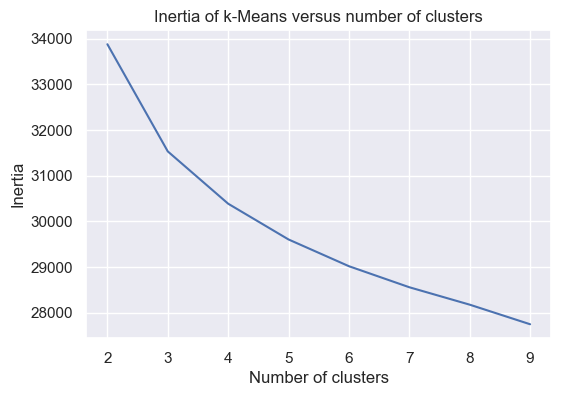

optimal_k:  4
cosine_kmeans - silhouette_score: 0.09098148915506063
Index(['numeric_id', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
       'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust',
       'nrc_ratio', 'nrc_negative', 'nrc_positive', 'liwc_Segment', 'liwc_WC',
       'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone',
       'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun',
       'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe',
       'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb',
       'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj',
       'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant',
       'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger',
       'liwc_sad', 'liwc_social', 'liwc_male', 'liwc_cogproc', 'liwc_insight',
       'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain',
       'liwc_differ', 'liwc_percept', 'liwc_se

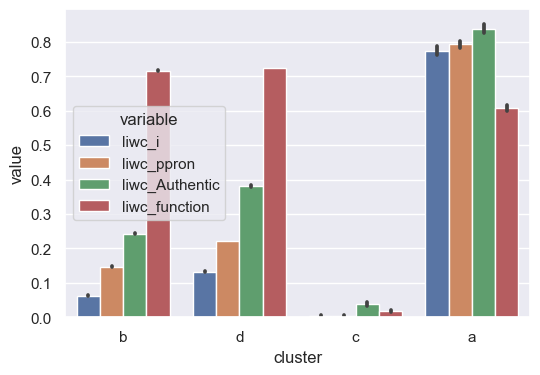

          Variable       Var
23          liwc_i  0.310127
22      liwc_ppron  0.300073
15  liwc_Authentic  0.294212
20   liwc_function  0.291204
data has 101932 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [55]:
conservative_significancy_result, conservative_predicted_df = run_cluster_analysis(conservative_features_df)

In [68]:
conservative_effect_cluster_df = conservative_predicted_df.merge(conservative_arguments_df[['effect']], 
                                how='inner', left_index= True, right_index=True)
#pd.crosstab(conservative_effect_cluster_df['effect'], conservative_effect_cluster_df['cluster'], normalize='index').plot(kind='bar')




### Liberals

getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
numeric_id
filtering our features wich has 75% of entries without a values
66844


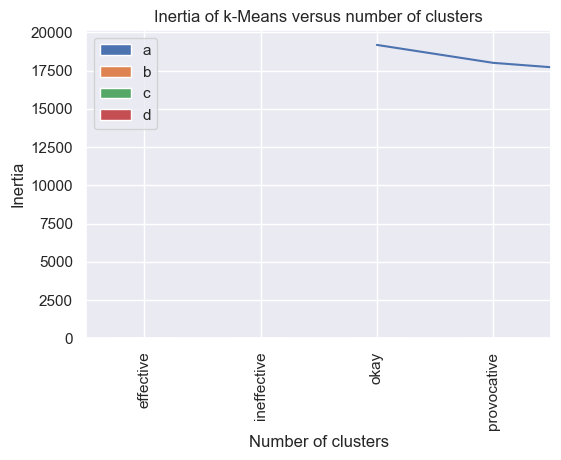

optimal_k:  4
cosine_kmeans - silhouette_score: 0.07008761943528558
Index(['numeric_id', 'nrc_anger', 'nrc_anticipation', 'nrc_disgust',
       'nrc_fear', 'nrc_joy', 'nrc_sadness', 'nrc_surprise', 'nrc_trust',
       'nrc_ratio', 'nrc_negative', 'nrc_positive', 'liwc_Segment', 'liwc_WC',
       'liwc_Analytic', 'liwc_Clout', 'liwc_Authentic', 'liwc_Tone',
       'liwc_WPS', 'liwc_Sixltr', 'liwc_Dic', 'liwc_function', 'liwc_pronoun',
       'liwc_ppron', 'liwc_i', 'liwc_we', 'liwc_you', 'liwc_shehe',
       'liwc_they', 'liwc_ipron', 'liwc_article', 'liwc_prep', 'liwc_auxverb',
       'liwc_adverb', 'liwc_conj', 'liwc_negate', 'liwc_verb', 'liwc_adj',
       'liwc_compare', 'liwc_interrog', 'liwc_number', 'liwc_quant',
       'liwc_affect', 'liwc_posemo', 'liwc_negemo', 'liwc_anx', 'liwc_anger',
       'liwc_sad', 'liwc_social', 'liwc_male', 'liwc_cogproc', 'liwc_insight',
       'liwc_cause', 'liwc_discrep', 'liwc_tentat', 'liwc_certain',
       'liwc_differ', 'liwc_percept', 'liwc_se

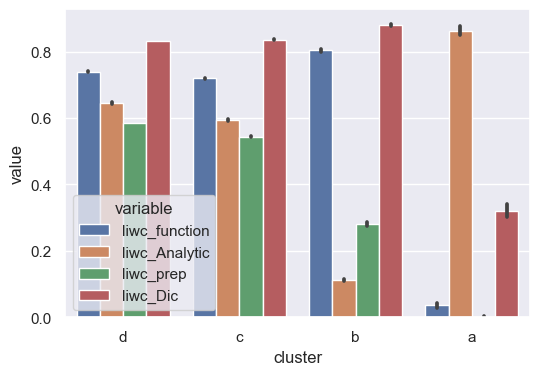

         Variable       Var
20  liwc_function  0.312607
13  liwc_Analytic   0.27447
30      liwc_prep  0.233928
19       liwc_Dic  0.229734
data has 66844 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [57]:
liberal_significancy_result, liberal_predicted_df = run_cluster_analysis(liberal_features_df)

In [70]:

liberal_effect_cluster_df = liberal_predicted_df.merge(liberal_arguments_df[['effect']], 
                                how='inner', left_index= True, right_index=True)
#pd.crosstab(liberal_effect_cluster_df['effect'], liberal_effect_cluster_df['cluster'], normalize='index').plot(kind='bar')

# PCA

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# PREPARE DATA FOR pca


#X_norm = (X - X.min())/(X.max() - X.min())
#X_standardized = StandardScaler().fit_transform(X)
def plot_pca(df, ideology):
    col=df.columns
    features=col.tolist() 
    feature=features[:-1] 
    target=features[-1]
    X=df.loc[:,feature].values  
    y=df.loc[:,target].values
    #Apply Standard Scaling
    sc=StandardScaler()  
    X=sc.fit_transform(X) 
    #pd.DataFrame(X,columns=feature).head()
    #Define two components  
    pca=PCA(n_components=2) 
    principalComponents=pca.fit_transform(X) 
    principalDf=pd.DataFrame(data=principalComponents,columns=['principal component 1','principal component 2']) 
    #principalDf.head()
    finalDf=pd.concat([principalDf,df[['effect']]],axis=1)
    
    fig=plt.figure(figsize=(8,8))  
    ax=fig.add_subplot(1,1,1)  
    ax.set_xlabel('Principal Component 1',fontsize = 15)  
    ax.set_ylabel('Principal Component 2',fontsize = 15)  
    ax.set_title(ideology,fontsize=20)  
    targets=list(df.effect.unique())
    colors= ['b', 'g', 'y', 'm']#sns.color_palette('deep')[:len(targets)]
    for target,color in zip(targets,colors):    
        indicesToKeep = finalDf['effect'] == target  
        ax.scatter(finalDf.loc[indicesToKeep,'principal component 1'],
                  finalDf.loc[indicesToKeep,'principal component 2'],
                 c=color,
                 s=50)
        ax.xaxis.label.set_color('white')
        ax.yaxis.label.set_color('white')
        ax.title.set_color('white')
        ax.tick_params(axis='x', colors='white')
        ax.tick_params(axis='y', colors='white')
        ax.legend(targets)  
        ax.grid()

    
    
    
    


getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...


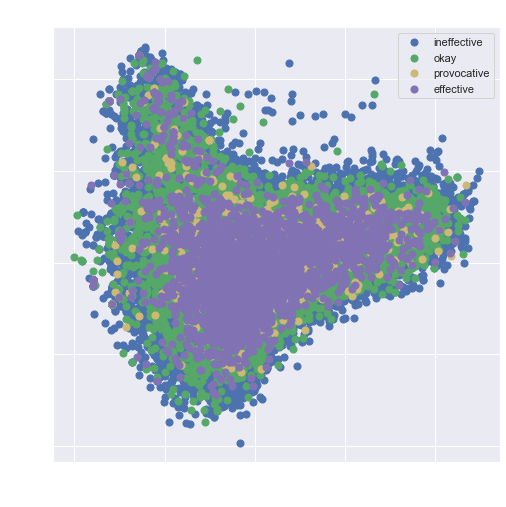

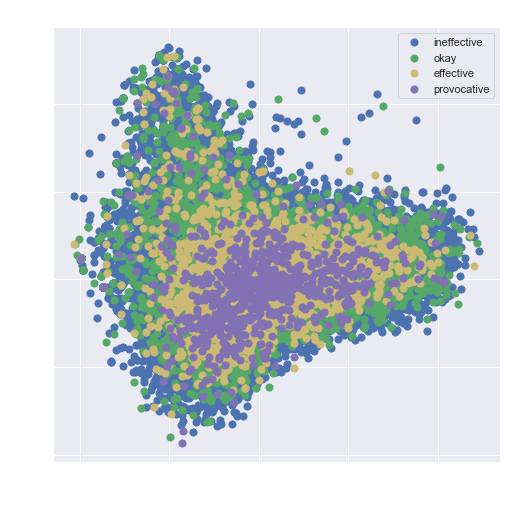

In [72]:
conservative_features_w_effect_df = prepare_data(conservative_features_df, normalizing_method="standard")
conservative_features_w_effect_df = conservative_features_w_effect_df.merge(conservative_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)



liberal_features_w_effect_df = prepare_data(liberal_features_df, normalizing_method="standard")
liberal_features_w_effect_df = liberal_features_w_effect_df.merge(liberal_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

plot_pca((conservative_features_w_effect_df), 'Conservative')
plot_pca((liberal_features_w_effect_df), 'Liberal')

In [73]:

# example of random oversampling to balance the class distribution

undersample(conservative_features_w_effect_df)

Counter({'effective': 906, 'ineffective': 906, 'okay': 906, 'provocative': 906})


,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_sadness,nrc_surprise,nrc_trust,nrc_ratio,nrc_negative,...,liwc_Colon,liwc_SemiC,liwc_QMark,liwc_Exclam,liwc_Dash,liwc_Quote,liwc_Apostro,liwc_Parenth,liwc_OtherP,effect
0,0.000000,0.000000,0.409612,0.000000,0.000000,0.328836,0.000000,0.091554,2.261621,0.151830,...,0.000000,0.000000,1.705509,0.000000,0.0,5.206321,0.943545,0.000000,0.000000,effective
1,0.123386,0.131049,0.000000,0.000000,0.000000,0.000000,0.000000,0.183108,5.406610,0.151830,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,effective
2,1.357249,1.572592,0.819225,0.679019,1.842208,0.000000,2.568151,1.007094,2.446311,0.531406,...,0.000000,0.000000,0.313257,0.000000,0.0,0.000000,0.693217,0.000000,0.000000,effective
3,0.863704,0.655247,0.819225,0.792188,0.184221,0.328836,0.000000,0.274662,1.652981,0.607321,...,0.686361,2.244118,0.000000,0.000000,0.0,1.582919,0.308096,0.000000,0.215595,effective
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.252754,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.008752,0.000000,0.000000,effective
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3619,0.000000,0.000000,0.000000,0.226340,0.000000,0.493254,0.000000,0.091554,2.155940,0.227745,...,0.000000,0.000000,0.809246,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,provocative
3620,0.246773,0.131049,0.000000,0.113170,0.000000,0.493254,0.321019,0.457770,2.488771,0.607321,...,0.000000,0.000000,0.504691,0.000000,0.0,0.000000,0.000000,0.898211,0.983653,provocative
3621,0.370159,0.131049,0.000000,0.113170,0.000000,0.164418,0.000000,0.000000,2.237183,0.227745,...,0.000000,0.000000,0.000000,0.000000,0.0,4.266462,0.000000,0.000000,0.000000,provocative
3622,1.357249,0.131049,1.228837,1.358037,0.000000,1.808598,0.963057,0.091554,2.917839,1.062812,...,0.000000,0.000000,0.513393,0.000000,0.0,1.465437,0.568052,2.272398,0.000000,provocative


# Significance between Effects


In [74]:
def calc_sign_effects(df, ideology):
    return significance_testing.significance(df, save=True, 
                                          desc='../data/significant_test/{}_effect'.format(ideology),
                                          independent_var='effect')


conservative_features_w_effect_df = prepare_data(conservative_features_df, normalizing_method="standard")
conservative_features_w_effect_df = conservative_features_w_effect_df.merge(conservative_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

liberal_features_w_effect_df = prepare_data(liberal_features_df, normalizing_method="standard")
liberal_features_w_effect_df = liberal_features_w_effect_df.merge(liberal_arguments_df[['effect']], 
                                                                   how='inner', left_index= True, right_index=True)

getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...
getting only numeric features from the training set...
There are 105  numeric features out of 105
Normalizing by using standard scaler...


In [75]:
conservative_significance_effect = calc_sign_effects(undersample(conservative_features_w_effect_df), 'conservative_undersampled')
liberal_significance_effect = calc_sign_effects(undersample(liberal_features_w_effect_df), 'liberal_undersampled')

Counter({'effective': 906, 'ineffective': 906, 'okay': 906, 'provocative': 906})
data has 3624 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal
Counter({'effective': 818, 'ineffective': 818, 'okay': 818, 'provocative': 818})
data has 3272 instances
bonforrini_threshold:  0.008333333333333333
exception for feature  All numbers are identical in kruskal


In [76]:
cons_discriminative_vals = conservative_significance_effect[conservative_significance_effect['effective ineffective']>0.1
                                ].sort_values(by=['effective ineffective'], ascending=False).index.values.tolist()

cons_discriminative_vals = ', '.join(cons_discriminative_vals)
cons_discriminative_vals

#'liwc_netspeak, liwc_AllPunc, liwc_WC, 
#liwc_Dash, liwc_OtherP, nrc_anger, nrc_disgust, nrc_fear, nrc_negative, liwc_number'

''

In [77]:
lib_discriminative_vals = liberal_significance_effect[liberal_significance_effect['effective ineffective']>0.09
                                ].sort_values(by=['effective ineffective'], ascending=False).index.values.tolist()

lib_discriminative_vals = ', '.join(lib_discriminative_vals)
lib_discriminative_vals

# 'liwc_AllPunc, liwc_shehe, liwc_OtherP'

'liwc_AllPunc, liwc_shehe, liwc_Dash, liwc_Colon'